# Importing Libraries

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd

# import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm

from PIL import Image

from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

# Loading Data and Preprocessing

In [3]:
# Load the training data path and labels
data_dir = '/Users/vishnu/Downloads/Human Action Recognition/train/'
train_csv = pd.read_csv('/Users/vishnu/Downloads/Human Action Recognition/Training_set.csv')
train_csv['filepath'] = train_csv['filename'].apply(lambda x: os.path.join(data_dir, x))

# Initialize Image Data Generator with preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow from dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=None,  # None because we provide absolute paths
    x_col='filepath',
    y_col='label',
    target_size=(160, 160),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

test_csv = pd.read_csv('/Users/vishnu/Downloads/Human Action Recognition/Testing_set.csv')  # Adjust this path as necessary
test_csv['filepath'] = test_csv['filename'].apply(lambda x: os.path.join('/Users/vishnu/Downloads/Human Action Recognition/test/', x))

test_datagen = ImageDataGenerator(rescale=1./255)

# Create the prediction generator
prediction_generator = test_datagen.flow_from_dataframe(
    dataframe=test_csv,
    directory=None,  # Use None if filepaths in 'filepath' are complete
    x_col='filepath',
    y_col=None,  # No labels
    target_size=(160, 160),
    color_mode='rgb',
    class_mode=None,  # No labels
    batch_size=32,
    shuffle=False
)


Found 12600 validated image filenames belonging to 15 classes.
Found 5400 validated image filenames.


# Model

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')  # Assuming 15 classes from your description
])



/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# #Train the model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.n // train_generator.batch_size,
#     epochs=60
# )
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define the initial learning rate
initial_learning_rate = 0.001

# Configure the optimizer with the initial learning rate
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint and ReduceLROnPlateau callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

# Train the model with the callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=60,
    callbacks=[checkpoint, reduce_lr]
)


In [7]:
model.save('my_model_action_recognition_2.h5')


In [ ]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# Model Prediciton

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted Action: cycling


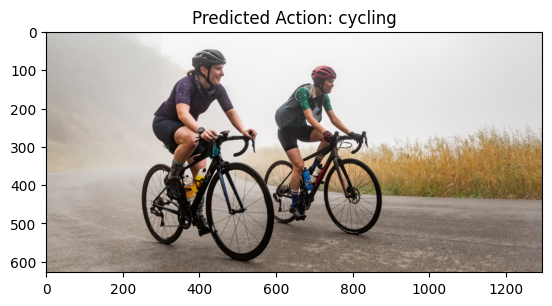

In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def load_and_prepare_image(image_path, target_size=(160, 160)):
    # Load the image
    img = load_img(image_path, target_size=target_size, color_mode='rgb')
    # Convert the image to an array
    img = img_to_array(img)
    # Rescale the image
    img = img / 255.0
    # Add an extra dimension for batch size
    img = np.expand_dims(img, axis=0)
    return img


model = load_model("/Users/vishnu/Desktop/viji files/sem 6/IR/Project/my_model_action_recognition.h5")
#model = load_model('/Users/vishnu/Downloads/vgg_model.h5')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Specify the path to your image
image_path = '/Users/vishnu/Downloads/benefits-of-cycling.jpg'

# Load and prepare the image
img = load_and_prepare_image(image_path)

# Predict the class
prediction = model.predict(img)
predicted_class = np.argmax(prediction, axis=1)

# Assuming you have a list of class names
class_names = ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
predicted_label = class_names[predicted_class[0]]

print(f"Predicted Action: {predicted_label}")

# Optionally display the image
plt.imshow(load_img(image_path))
plt.title(f"Predicted Action: {predicted_label}")
plt.show()


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,335,119 (81.39 MB)

 Trainable params: 21,335,119 (81.39 MB)

 Non-trainable params: 0 (0.00 B)